In [1]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [10]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 52.7 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.4/584.4 kB 74.0 MB/s  0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.4.0
    Uninstalling typing_extensions-4.4.0:
      Successfully uninstalled typing_extensions-4.4.00/7 [typing-extensions]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [optuna]2m6/7 [optuna]]my]
Note: you may need to restart the kernel to use updated packages.


In [12]:
# ============================================================
# CNN Baseline dengan Hyperparameter Tuning menggunakan Optuna
# ============================================================
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (classification_report, confusion_matrix,
                             ConfusionMatrixDisplay, accuracy_score,
                             precision_score, recall_score, f1_score)
import matplotlib.pyplot as plt
import random
import optuna
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# ---------------------------
# 0. Reproducibility & Device
# ---------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [13]:

# ============================================================
# CNN Baseline dengan Hyperparameter Tuning menggunakan Optuna
# ============================================================
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (classification_report, confusion_matrix,
                             ConfusionMatrixDisplay, accuracy_score,
                             precision_score, recall_score, f1_score)
import matplotlib.pyplot as plt
import random
import optuna
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# ---------------------------
# 0. Reproducibility & Device
# ---------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ---------------------------
# 1. Load Data
# ---------------------------
gaf_images = np.load("gaf_images2.npy")   # (N, 64, 64)
labels = np.load("y_train_all.npy")       # (N,)

assert len(gaf_images) == len(labels), "Jumlah sampel gambar & label harus sama."
num_classes = len(np.unique(labels))
print("Data shape:", gaf_images.shape, "Classes:", np.unique(labels))

# Normalisasi ke [0,1]
if gaf_images.max() > 1.0 or gaf_images.min() < 0.0:
    gmax = gaf_images.max()
    gmin = gaf_images.min()
    if gmax != gmin:
        gaf_images = (gaf_images - gmin) / (gmax - gmin)

# ---------------------------
# 2. Dataset & Dataloader
# ---------------------------
class GAFImageDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images.astype(np.float32)
        self.labels = labels.astype(np.int64)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = self.images[idx]  # (64, 64)
        # Add channel dimension => (1, 64, 64)
        img = np.expand_dims(img, axis=0)
        img = torch.from_numpy(img)  # float32
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return img, label


Using device: cuda
Data shape: (22400, 64, 64) Classes: [0 1 2 3]


In [14]:
# ---------------------------
# 3. Improved CNN Model dengan Batch Normalization dan Skip Connections
# ---------------------------
class ImprovedCNN(nn.Module):
    def __init__(self, num_classes=4, in_ch=1, dropout_rate=0.3, 
                 filters_base=32, hidden_dim=256):
        super().__init__()
        
        # First block
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_ch, filters_base, kernel_size=3, padding=1),
            nn.BatchNorm2d(filters_base),
            nn.ReLU(inplace=True),
            nn.Conv2d(filters_base, filters_base, kernel_size=3, padding=1),
            nn.BatchNorm2d(filters_base),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)  # 64->32
        )
        
        # Second block
        self.conv2 = nn.Sequential(
            nn.Conv2d(filters_base, filters_base*2, kernel_size=3, padding=1),
            nn.BatchNorm2d(filters_base*2),
            nn.ReLU(inplace=True),
            nn.Conv2d(filters_base*2, filters_base*2, kernel_size=3, padding=1),
            nn.BatchNorm2d(filters_base*2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)  # 32->16
        )
        
        # Third block
        self.conv3 = nn.Sequential(
            nn.Conv2d(filters_base*2, filters_base*4, kernel_size=3, padding=1),
            nn.BatchNorm2d(filters_base*4),
            nn.ReLU(inplace=True),
            nn.Conv2d(filters_base*4, filters_base*4, kernel_size=3, padding=1),
            nn.BatchNorm2d(filters_base*4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)  # 16->8
        )
        
        # Fourth block (optional)
        self.conv4 = nn.Sequential(
            nn.Conv2d(filters_base*4, filters_base*8, kernel_size=3, padding=1),
            nn.BatchNorm2d(filters_base*8),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1)  # Global Average Pooling
        )
        
        # Classifier
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(filters_base*8, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.conv1(x)    # (B,32,32,32)
        x = self.conv2(x)    # (B,64,16,16)
        x = self.conv3(x)    # (B,128,8,8)
        x = self.conv4(x)    # (B,256,1,1)
        
        x = x.view(x.size(0), -1)  # Flatten
        x = self.dropout1(x)
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

# ---------------------------
# 4. Training Utilities
# ---------------------------
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model(imgs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

@torch.no_grad()
def eval_one_epoch(model, loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    all_y_true, all_y_pred = [], []
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        logits = model(imgs)
        loss = criterion(logits, labels)
        running_loss += loss.item() * labels.size(0)
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        all_y_true.extend(labels.cpu().numpy())
        all_y_pred.extend(preds.cpu().numpy())
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc, np.array(all_y_true), np.array(all_y_pred)

def ensure_dir(p):
    os.makedirs(p, exist_ok=True)

# ---------------------------
# 5. Configuration - Fixed Hyperparameters
# ---------------------------
# Optimized hyperparameters based on common CNN best practices
BATCH_SIZE = 128
LR = 0.001
DROPOUT_RATE = 0.3
FILTERS_BASE = 32
HIDDEN_DIM = 256
WEIGHT_DECAY = 1e-4
SCHEDULER_FACTOR = 0.2
SCHEDULER_PATIENCE = 5
EPOCHS = 20


In [15]:
# ---------------------------
# 6. Cross-Validation Training
# ---------------------------
print("Training CNN with fixed hyperparameters...")

class_names = ["N", "S", "V", "Q"][:num_classes]
out_dir = "cnn_tuning"
ensure_dir(out_dir)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
fold_metrics = []
per_class_metrics = []

X = gaf_images
y = labels

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"\n========== Fold {fold+1}/5 ==========")
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    train_ds = GAFImageDataset(X_train, y_train)
    val_ds = GAFImageDataset(X_val, y_val)
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, 
                              num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, 
                            num_workers=2, pin_memory=True)

    model = ImprovedCNN(num_classes=num_classes, in_ch=1, 
                       dropout_rate=DROPOUT_RATE, filters_base=FILTERS_BASE,
                       hidden_dim=HIDDEN_DIM).to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=SCHEDULER_FACTOR, 
        patience=SCHEDULER_PATIENCE, verbose=False
    )

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    best_val_acc = -1.0
    best_state = None
    patience_counter = 0
    early_stop_patience = 12

    for epoch in range(1, EPOCHS+1):
        tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc, y_true_ep, y_pred_ep = eval_one_epoch(model, val_loader, criterion, device)

        train_losses.append(tr_loss)
        val_losses.append(val_loss)
        train_accuracies.append(tr_acc)
        val_accuracies.append(val_acc)

        scheduler.step(val_acc)

        print(f"Epoch {epoch:02d}/{EPOCHS} | "
              f"Train Loss: {tr_loss:.4f} Acc: {tr_acc:.4f} | "
              f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f} | "
              f"LR: {optimizer.param_groups[0]['lr']:.2e}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= early_stop_patience:
            print(f"Early stopping at epoch {epoch}")
            break

    # Restore best model and save
    model.load_state_dict(best_state)
    torch.save(model.state_dict(), os.path.join(out_dir, f"cnn_tuned_fold{fold+1}.pth"))
    print(f"✅ Model saved: {os.path.join(out_dir, f'cnn_tuned_fold{fold+1}.pth')}")

    # Final evaluation
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for imgs, labels_b in val_loader:
            imgs = imgs.to(device)
            logits = model(imgs)
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            y_pred.extend(preds)
            y_true.extend(labels_b.numpy())

    # Metrics calculation
    report = classification_report(y_true, y_pred, output_dict=True,
                                   target_names=class_names, zero_division=0)
    cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))

    # Specificity calculation
    cm_sum = cm.sum()
    TP = np.diag(cm)
    FP = cm.sum(axis=0) - TP
    FN = cm.sum(axis=1) - TP
    TN = cm_sum - (TP + FP + FN)
    specificity_per_class = TN / (TN + FP + 1e-8)

    # Save per-class metrics
    for i, cname in enumerate(class_names):
        per_class_metrics.append({
            "Fold": f"Fold {fold+1}",
            "Class": cname,
            "Precision": report[cname]["precision"],
            "Sensitivity": report[cname]["recall"],
            "Specificity": specificity_per_class[i],
            "F1-Score": report[cname]["f1-score"]
        })

    # Fold summary metrics
    fold_summary = {
        "Fold": fold+1,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, average="weighted", zero_division=0),
        "Sensitivity": recall_score(y_true, y_pred, average="weighted", zero_division=0),
        "Specificity": specificity_per_class.mean(),
        "F1-Score": f1_score(y_true, y_pred, average="weighted", zero_division=0)
    }
    fold_metrics.append(fold_summary)

    # Save visualizations for each fold
    # Confusion Matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(5.5, 5))
    disp.plot(ax=ax, cmap="Blues", colorbar=False, values_format="d")
    plt.title(f"Confusion Matrix CNN Tuning - Fold {fold+1}")
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"cnn_tuned_confusion_matrix_fold{fold+1}.png"))
    plt.close(fig)

    # Accuracy curve
    plt.figure()
    plt.plot(train_accuracies, label="Train Accuracy")
    plt.plot(val_accuracies, label="Validation Accuracy")
    plt.title(f"Training and Validation Accuracy - Fold {fold+1}")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"cnn_tuned_accuracy_fold{fold+1}.png"))
    plt.close()

    # Loss curve
    plt.figure()
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.title(f"Training and Validation Loss - Fold {fold+1}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"cnn_tuned_loss_fold{fold+1}.png"))
    plt.close()

# ---------------------------
# 7. Save Final Results
# ---------------------------
df_per_class = pd.DataFrame(per_class_metrics)
df_per_class.to_csv(os.path.join(out_dir, "cnn_tuned_table5_per_class_metrics.csv"), index=False)

df_fold = pd.DataFrame(fold_metrics)
avg_metrics = df_fold[["Accuracy","Precision","Sensitivity","Specificity","F1-Score"]].mean(numeric_only=True)
avg_row = {"Fold": "Average"}
avg_row.update({k: float(v) for k, v in avg_metrics.to_dict().items()})
df_fold = pd.concat([df_fold, pd.DataFrame([avg_row])], ignore_index=True)
df_fold.to_csv(os.path.join(out_dir, "cnn_tuned_table3_4_fold_summary_metrics.csv"), index=False)

print("\n✅ Semua model, grafik, dan metrik CNN tuned disimpan di folder:", out_dir)

# Print final results
print("\n=== Final Results Summary ===")
print(f"Average Accuracy: {avg_metrics['Accuracy']:.4f}")
print(f"Average Precision: {avg_metrics['Precision']:.4f}")
print(f"Average Sensitivity: {avg_metrics['Sensitivity']:.4f}")
print(f"Average Specificity: {avg_metrics['Specificity']:.4f}")
print(f"Average F1-Score: {avg_metrics['F1-Score']:.4f}")

# Save hyperparameter configuration
config_dict = {
    "batch_size": BATCH_SIZE,
    "learning_rate": LR,
    "dropout_rate": DROPOUT_RATE,
    "filters_base": FILTERS_BASE,
    "hidden_dim": HIDDEN_DIM,
    "weight_decay": WEIGHT_DECAY,
    "scheduler_factor": SCHEDULER_FACTOR,
    "scheduler_patience": SCHEDULER_PATIENCE,
    "epochs": EPOCHS
}

config_df = pd.DataFrame([config_dict])
config_df.to_csv(os.path.join(out_dir, "hyperparameters_config.csv"), index=False)
print(f"Hyperparameter configuration saved to: {os.path.join(out_dir, 'hyperparameters_config.csv')}")

Training CNN with fixed hyperparameters...

========== Fold 1/5 ==========
Epoch 01/20 | Train Loss: 0.2512 Acc: 0.9161 | Val Loss: 0.4722 Acc: 0.8531 | LR: 1.00e-03
Epoch 02/20 | Train Loss: 0.1407 Acc: 0.9555 | Val Loss: 0.1691 Acc: 0.9480 | LR: 1.00e-03
Epoch 03/20 | Train Loss: 0.1170 Acc: 0.9624 | Val Loss: 0.2439 Acc: 0.9243 | LR: 1.00e-03
Epoch 04/20 | Train Loss: 0.0955 Acc: 0.9684 | Val Loss: 0.1064 Acc: 0.9701 | LR: 1.00e-03
Epoch 05/20 | Train Loss: 0.0926 Acc: 0.9714 | Val Loss: 0.1556 Acc: 0.9480 | LR: 1.00e-03
Epoch 06/20 | Train Loss: 0.0810 Acc: 0.9741 | Val Loss: 0.1574 Acc: 0.9567 | LR: 1.00e-03
Epoch 07/20 | Train Loss: 0.0717 Acc: 0.9763 | Val Loss: 0.1235 Acc: 0.9654 | LR: 1.00e-03
Epoch 08/20 | Train Loss: 0.0629 Acc: 0.9797 | Val Loss: 0.1166 Acc: 0.9676 | LR: 1.00e-03
Epoch 09/20 | Train Loss: 0.0608 Acc: 0.9790 | Val Loss: 0.0984 Acc: 0.9739 | LR: 1.00e-03
Epoch 10/20 | Train Loss: 0.0544 Acc: 0.9821 | Val Loss: 0.1318 Acc: 0.9645 | LR: 1.00e-03
Epoch 11/20 | T

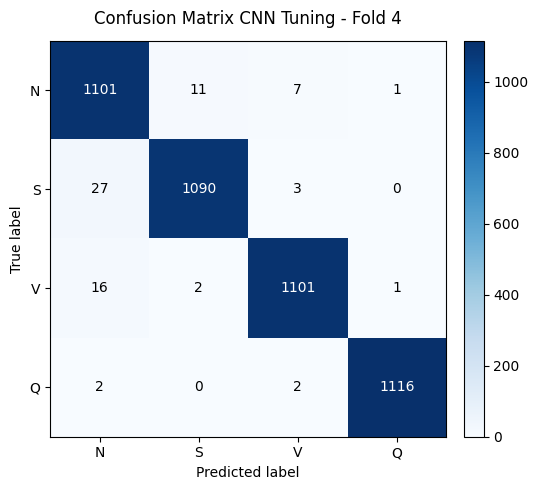

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Confusion matrix (CNN Tuning - Fold 4)
cm = np.array([
    [1101,  11,   7,   1],  # True N
    [  27, 1090,  3,   0],  # True S
    [  16,   2, 1101,  1],  # True V
    [   2,   0,   2, 1116]  # True Q
], dtype=int)

classes = ['N', 'S', 'V', 'Q']

# Plot sederhana tanpa grid
fig, ax = plt.subplots(figsize=(5.5, 5))
im = ax.imshow(cm, cmap='Blues', interpolation='nearest')

ax.set_title('Confusion Matrix CNN Tuning - Fold 4', pad=12)
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(classes)))
ax.set_xticklabels(classes)
ax.set_yticklabels(classes)

# Colorbar
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

# Anotasi nilai di tiap sel
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, f'{cm[i, j]}',
                ha='center', va='center',
                color='white' if cm[i, j] > thresh else 'black',
                fontsize=10)

plt.tight_layout()
plt.savefig('cnn_tuning_confusionmatrix_fold4.png', dpi=150, bbox_inches='tight')  # opsional
plt.show()


In [ ]:
EXTERNAL TEST

External test set loaded: (5600, 64, 64), (5600,)
Data normalized from [-1.000, 1.000] to [0, 1]
Test loader created with batch size: 128
Using default hyperparameters
Loading checkpoint from: cnn_tuning/cnn_tuned_fold4.pth
Model loaded successfully!
Total parameters: 650,340
Trainable parameters: 650,340
Starting evaluation on external test set...


Evaluasi External Test Set (CNN Tuned): 100%|██████████| 44/44 [00:00<00:00, 175.77it/s]


Evaluation completed. Total samples: 5600

=== Evaluasi pada External Test Set (CNN Tuned) ===
              precision    recall  f1-score   support

           N   0.901243  0.984286  0.940935      1400
           S   0.984202  0.890000  0.934734      1400
           V   0.981534  0.987143  0.984330      1400
           Q   0.998568  0.996429  0.997497      1400

    accuracy                       0.964464      5600
   macro avg   0.966387  0.964464  0.964374      5600
weighted avg   0.966387  0.964464  0.964374      5600



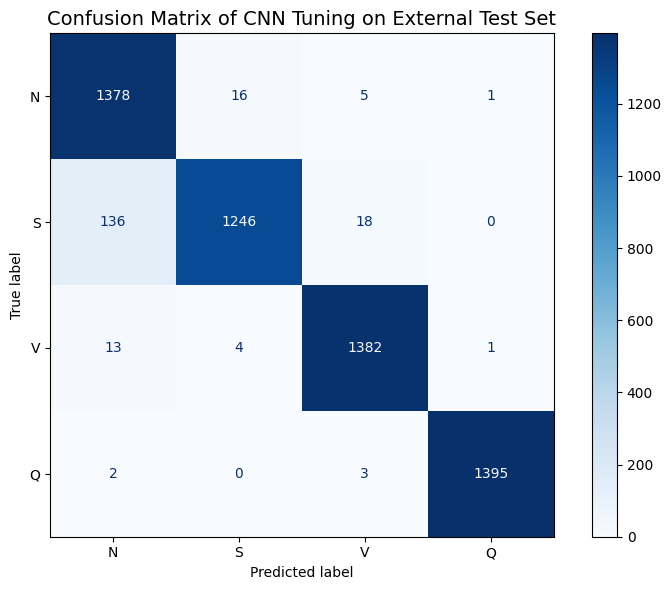

Confusion matrix disimpan ke: cnn_tuning_externaltest/confusion_matrix_external_cnn_tuned.png

=== Ringkasan Evaluasi (External Test Set - CNN Tuned) ===
Accuracy   : 0.964464
Precision  : 0.966387
Sensitivity: 0.964464
Specificity: 0.988155
F1-Score   : 0.964374

CSV disimpan:
- cnn_tuning_externaltest/external_summary_metrics_tuned.csv
- cnn_tuning_externaltest/external_per_class_metrics_tuned.csv
AUC Macro  : 0.997175
AUC Micro  : 0.997682

=== Evaluasi Kuantitatif Tambahan ===
Model Size        : 2.49 MB
Average Inference : 0.000008 detik/sample
Total Inference   : 0.047 detik
CPU Memory Usage  : 3099.77 MB
GPU Memory Usage  : 0.00 MB

=== Perbandingan dengan CNN Baseline ===
Baseline Accuracy : 0.921071
Tuned Accuracy    : 0.964464
Accuracy Improvement: +4.71%

Baseline F1-Score : 0.920230
Tuned F1-Score    : 0.964374
F1-Score Improvement: +4.80%

✅ Evaluasi external test selesai!
📁 Semua hasil disimpan di folder: cnn_tuning_externaltest
📊 Extended summary: cnn_tuning_externaltest

In [26]:
# External Test - CNN Tuned (GAF-only) 
import os, time, numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import (classification_report, confusion_matrix,
                             ConfusionMatrixDisplay, accuracy_score,
                             precision_score, recall_score, f1_score,
                             roc_auc_score)
from tqdm import tqdm
import pandas as pd

# ====== Config ======
BATCH_SIZE    = 128  # Sesuai dengan training tuned
NUM_CLASSES   = 4
CLASS_NAMES   = ['N', 'S', 'V', 'Q']
DEVICE        = "cuda" if torch.cuda.is_available() else "cpu"

CKPT_PATH     = "cnn_tuning/cnn_tuned_fold4.pth"   # fold terbaik
X_IMG_PATH    = "gaf_images_test.npy"
Y_LABEL_PATH  = "y_test_final.npy"

OUT_DIR       = "cnn_tuning_externaltest"
os.makedirs(OUT_DIR, exist_ok=True)
SAVE_CM_PNG   = os.path.join(OUT_DIR, "confusion_matrix_external_cnn_tuned.png")
SAVE_REPORT   = os.path.join(OUT_DIR, "classification_report_external_tuned.txt")
SAVE_SUMMARY  = os.path.join(OUT_DIR, "external_summary_metrics_tuned.csv")
SAVE_PERCLS   = os.path.join(OUT_DIR, "external_per_class_metrics_tuned.csv")

# ====== Load External Test Set ======
X_image = np.load(X_IMG_PATH)  # (N,H,W) atau (N,1,H,W)
y_label = np.load(Y_LABEL_PATH)

print(f"External test set loaded: {X_image.shape}, {y_label.shape}")

# Samakan normalisasi dengan training: skala ke [0,1] bila di luar range
if X_image.max() > 1.0 or X_image.min() < 0.0:
    gmax, gmin = X_image.max(), X_image.min()
    if gmax != gmin:
        X_image = (X_image - gmin) / (gmax - gmin)
        print(f"Data normalized from [{gmin:.3f}, {gmax:.3f}] to [0, 1]")

X_image_t = torch.tensor(X_image, dtype=torch.float32)
if X_image_t.ndim == 3:
    X_image_t = X_image_t.unsqueeze(1)  # (N,1,H,W)
elif X_image_t.ndim == 4 and X_image_t.size(1) in (1,3):
    pass
else:
    raise ValueError(f"Bentuk X_image tidak dikenali: {tuple(X_image_t.shape)}")

y_label_t = torch.tensor(y_label, dtype=torch.long)

test_ds     = TensorDataset(X_image_t, y_label_t)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

print(f"Test loader created with batch size: {BATCH_SIZE}")

# ====== Model: Improved CNN (sesuai dengan training tuned) ======
class ImprovedCNN(nn.Module):
    def __init__(self, num_classes=4, in_ch=1, dropout_rate=0.3, 
                 filters_base=32, hidden_dim=256):
        super().__init__()
        
        # First block
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_ch, filters_base, kernel_size=3, padding=1),
            nn.BatchNorm2d(filters_base),
            nn.ReLU(inplace=True),
            nn.Conv2d(filters_base, filters_base, kernel_size=3, padding=1),
            nn.BatchNorm2d(filters_base),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)  # 64->32
        )
        
        # Second block
        self.conv2 = nn.Sequential(
            nn.Conv2d(filters_base, filters_base*2, kernel_size=3, padding=1),
            nn.BatchNorm2d(filters_base*2),
            nn.ReLU(inplace=True),
            nn.Conv2d(filters_base*2, filters_base*2, kernel_size=3, padding=1),
            nn.BatchNorm2d(filters_base*2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)  # 32->16
        )
        
        # Third block
        self.conv3 = nn.Sequential(
            nn.Conv2d(filters_base*2, filters_base*4, kernel_size=3, padding=1),
            nn.BatchNorm2d(filters_base*4),
            nn.ReLU(inplace=True),
            nn.Conv2d(filters_base*4, filters_base*4, kernel_size=3, padding=1),
            nn.BatchNorm2d(filters_base*4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)  # 16->8
        )
        
        # Fourth block (optional)
        self.conv4 = nn.Sequential(
            nn.Conv2d(filters_base*4, filters_base*8, kernel_size=3, padding=1),
            nn.BatchNorm2d(filters_base*8),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1)  # Global Average Pooling
        )
        
        # Classifier
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(filters_base*8, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.conv1(x)    # (B,32,32,32)
        x = self.conv2(x)    # (B,64,16,16)
        x = self.conv3(x)    # (B,128,8,8)
        x = self.conv4(x)    # (B,256,1,1)
        
        x = x.view(x.size(0), -1)  # Flatten
        x = self.dropout1(x)
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

# ====== Load checkpoint (STRICT) ======
in_channels = X_image_t.size(1)

# Load hyperparameters dari config yang disimpan
config_path = "cnn_tuned/hyperparameters_config.csv"
if os.path.exists(config_path):
    config_df = pd.read_csv(config_path)
    config = config_df.iloc[0].to_dict()
    dropout_rate = config['dropout_rate']
    filters_base = int(config['filters_base'])
    hidden_dim = int(config['hidden_dim'])
    print(f"Loaded hyperparameters: dropout={dropout_rate}, filters_base={filters_base}, hidden_dim={hidden_dim}")
else:
    # Default values jika config tidak ada
    dropout_rate = 0.3
    filters_base = 32
    hidden_dim = 256
    print("Using default hyperparameters")

model = ImprovedCNN(
    num_classes=NUM_CLASSES, 
    in_ch=in_channels,
    dropout_rate=dropout_rate,
    filters_base=filters_base,
    hidden_dim=hidden_dim
).to(DEVICE)

if not os.path.exists(CKPT_PATH):
    raise FileNotFoundError(f"Checkpoint tidak ditemukan: {CKPT_PATH}")

print(f"Loading checkpoint from: {CKPT_PATH}")
state = torch.load(CKPT_PATH, map_location=DEVICE)
if isinstance(state, dict) and 'state_dict' in state:
    state = state['state_dict']
# bersihkan prefix 'module.' kalau ada
state = {k.replace("module.", ""): v for k, v in state.items()}
# Pakai strict=True agar ketahuan jika arsitektur beda
model.load_state_dict(state, strict=True)
model.eval()

print("Model loaded successfully!")

# ====== Count Parameters ======
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# ====== Evaluate ======
all_preds, all_labels, all_logits = [], [], []
inference_times = []

print("Starting evaluation on external test set...")

with torch.no_grad():
    for imgs, labels in tqdm(test_loader, desc="Evaluasi External Test Set (CNN Tuned)"):
        imgs   = imgs.to(DEVICE, non_blocking=True)
        labels = labels.to(DEVICE, non_blocking=True)

        t0 = time.perf_counter()
        logits = model(imgs)
        t1 = time.perf_counter()

        preds = torch.argmax(logits, dim=1)

        all_logits.append(logits.cpu())
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        inference_times.append((t1 - t0) / imgs.size(0))

all_logits = torch.cat(all_logits, dim=0)
y_probs = torch.softmax(all_logits, dim=1).numpy()
y_true  = np.array(all_labels)
y_pred  = np.array(all_preds)

print(f"Evaluation completed. Total samples: {len(y_true)}")

# ====== Report & Confusion Matrix ======
report_txt = classification_report(y_true, y_pred, target_names=CLASS_NAMES, digits=6)
print("\n=== Evaluasi pada External Test Set (CNN Tuned) ===")
print(report_txt)
with open(SAVE_REPORT, "w") as f:
    f.write(report_txt)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(
    y_true, y_pred, display_labels=CLASS_NAMES, cmap="Blues", values_format="d", ax=ax
)
plt.title("Confusion Matrix of CNN Tuning on External Test Set", fontsize=14)
plt.tight_layout()
plt.savefig(SAVE_CM_PNG, dpi=150, bbox_inches='tight')
plt.show()
print(f"Confusion matrix disimpan ke: {SAVE_CM_PNG}")

# ====== Ringkasan Metrik ======
acc  = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average="weighted", zero_division=0)
rec  = recall_score(y_true, y_pred, average="weighted", zero_division=0)
f1   = f1_score(y_true, y_pred, average="weighted", zero_division=0)

cm = confusion_matrix(y_true, y_pred, labels=list(range(NUM_CLASSES)))
TP = np.diag(cm)
FP = cm.sum(axis=0) - TP
FN = cm.sum(axis=1) - TP
TN = cm.sum() - (TP + FP + FN)
spec_per_cls = TN / (TN + FP + 1e-8)
spec_mean = spec_per_cls.mean()

print("\n=== Ringkasan Evaluasi (External Test Set - CNN Tuned) ===")
print(f"Accuracy   : {acc:.6f}")
print(f"Precision  : {prec:.6f}")
print(f"Sensitivity: {rec:.6f}")
print(f"Specificity: {spec_mean:.6f}")
print(f"F1-Score   : {f1:.6f}")

# ====== Per-Class Metrics (Fixed calculation) ======
# Calculate per-class metrics correctly
per_class_precision = []
per_class_recall = []
per_class_f1 = []

for i in range(NUM_CLASSES):
    # Create binary classification for each class
    y_true_binary = (y_true == i).astype(int)
    y_pred_binary = (y_pred == i).astype(int)
    
    per_class_precision.append(precision_score(y_true_binary, y_pred_binary, zero_division=0))
    per_class_recall.append(recall_score(y_true_binary, y_pred_binary, zero_division=0))
    per_class_f1.append(f1_score(y_true_binary, y_pred_binary, zero_division=0))

# Simpan summary CSV
summary_df = pd.DataFrame([{
    "Accuracy": acc, 
    "Precision": prec, 
    "Sensitivity": rec,
    "Specificity": float(spec_mean), 
    "F1-Score": f1,
    "AvgInference(s/sample)": float(np.mean(inference_times)) if inference_times else np.nan
}])
summary_df.to_csv(SAVE_SUMMARY, index=False)

# Simpan per-class CSV
percls_df = pd.DataFrame({
    "Class": CLASS_NAMES,
    "Precision": per_class_precision,
    "Sensitivity": per_class_recall,  # Sensitivity = Recall
    "Specificity": spec_per_cls,
    "F1-Score": per_class_f1
})
percls_df.to_csv(SAVE_PERCLS, index=False)

print(f"\nCSV disimpan:\n- {SAVE_SUMMARY}\n- {SAVE_PERCLS}")

# ====== ROC-AUC ======
try:
    y_true_1hot = np.eye(NUM_CLASSES)[y_true]
    auc_macro   = roc_auc_score(y_true_1hot, y_probs, average='macro', multi_class='ovr')
    auc_micro   = roc_auc_score(y_true_1hot, y_probs, average='micro', multi_class='ovr')
    print(f"AUC Macro  : {auc_macro:.6f}")
    print(f"AUC Micro  : {auc_micro:.6f}")
except Exception as e:
    print("ROC AUC Calculation failed:", e)
    auc_macro = np.nan
    auc_micro = np.nan

# ====== Model Size & Memory Analysis ======
try:
    import psutil
    cpu_mem_mb = psutil.Process().memory_info().rss / 1024**2
except Exception:
    cpu_mem_mb = float('nan')

try:
    import GPUtil
    gpu_mem_mb = GPUtil.getGPUs()[0].memoryUsed if torch.cuda.is_available() else 0
except Exception:
    gpu_mem_mb = 0

param_size  = sum(p.numel() * p.element_size() for p in model.parameters())
buffer_size = sum(b.numel() * b.element_size() for b in model.buffers())
model_size_mb = (param_size + buffer_size) / 1024**2
avg_infer_time = float(np.mean(inference_times)) if len(inference_times) else float('nan')

print("\n=== Evaluasi Kuantitatif Tambahan ===")
print(f"Model Size        : {model_size_mb:.2f} MB")
print(f"Average Inference : {avg_infer_time:.6f} detik/sample")
print(f"Total Inference   : {avg_infer_time * len(y_true):.3f} detik")
print(f"CPU Memory Usage  : {cpu_mem_mb:.2f} MB")
print(f"GPU Memory Usage  : {gpu_mem_mb:.2f} MB")

# ====== Performance Comparison with Baseline ======
baseline_csv = "cnn_non_tuning_externaltest/external_summary_metrics.csv"
if os.path.exists(baseline_csv):
    try:
        baseline_df = pd.read_csv(baseline_csv)
        baseline_acc = baseline_df.iloc[0]['Accuracy']
        baseline_f1 = baseline_df.iloc[0]['F1-Score']
        
        acc_improvement = ((acc - baseline_acc) / baseline_acc) * 100
        f1_improvement = ((f1 - baseline_f1) / baseline_f1) * 100
        
        print(f"\n=== Perbandingan dengan CNN Baseline ===")
        print(f"Baseline Accuracy : {baseline_acc:.6f}")
        print(f"Tuned Accuracy    : {acc:.6f}")
        print(f"Accuracy Improvement: {acc_improvement:+.2f}%")
        print(f"")
        print(f"Baseline F1-Score : {baseline_f1:.6f}")
        print(f"Tuned F1-Score    : {f1:.6f}")
        print(f"F1-Score Improvement: {f1_improvement:+.2f}%")
        
    except Exception as e:
        print(f"Could not compare with baseline: {e}")

# ====== Save Extended Summary ======
extended_summary = {
    "Accuracy": acc,
    "Precision": prec,
    "Sensitivity": rec,
    "Specificity": float(spec_mean),
    "F1-Score": f1,
    "AUC_Macro": auc_macro,
    "AUC_Micro": auc_micro,
    "Model_Size_MB": model_size_mb,
    "Avg_Inference_Time": avg_infer_time,
    "Total_Parameters": total_params,
    "Trainable_Parameters": trainable_params
}

extended_df = pd.DataFrame([extended_summary])
extended_df.to_csv(os.path.join(OUT_DIR, "extended_summary_metrics.csv"), index=False)

print(f"\n✅ Evaluasi external test selesai!")
print(f"📁 Semua hasil disimpan di folder: {OUT_DIR}")
print(f"📊 Extended summary: {os.path.join(OUT_DIR, 'extended_summary_metrics.csv')}")